In [1]:
%matplotlib inline 

In [2]:
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt

from models import RNNGC
from plotting_functions import multiimshow
from dataset import DatasetMaker
from tqdm import tqdm

In [3]:
def step_forward(g, v, r, target = -1):
    # super janky
    model = RNNGC()
    model = model.load("./saved-models/RNNGC.pkl")
    gs = []
    for i in range(v.shape[1]):
        g = model.recurrent_step(g, v[:,i])
        gs.append(g)
    return model.distance_loss(g, r[:,target])

In [4]:
samples = 10000
timesteps = 10

In [5]:
model = RNNGC()
model = model.load("./best_models/RNNGC.pkl")

In [6]:
dataset = DatasetMaker()

In [7]:
r, v = dataset.generate_data(samples, timesteps)
g = model((r[:,0], v)) #

In [8]:
grads = []
for i in tqdm(range(v.shape[1])):
    g_prev = g[:,i].detach()
    grad = torch.autograd.functional.jacobian(step_forward, (g_prev, v, r))
    grads.append(grad[0].detach().numpy())
grads = np.stack(grads, axis = 1)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [01:06<00:00,  7.38s/it]


In [9]:
avg_gradients = np.mean(grads, axis = 0)
avg_gradients.shape

(9, 256)

In [10]:
slopes = [np.polyfit(np.arange(timesteps-1), avg_gradient, 1)[0] for avg_gradient in avg_gradients.T]
inds = np.argsort(slopes)

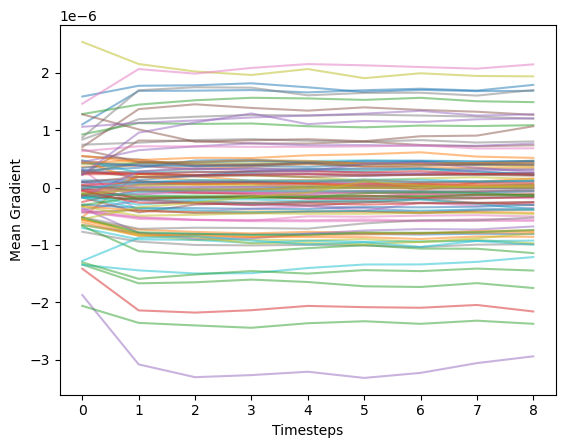

In [11]:
for i in range(100):
    plt.plot(avg_gradients[:,i], alpha = 0.5)#, label = f"{slopes[i]:.1e}");
#plt.legend(frameon = False)
plt.xlabel("Timesteps")
plt.ylabel("Mean Gradient")
plt.savefig("./figures/test.png", dpi = 300)

In [12]:
r = r.detach().numpy()
g = g.detach().numpy()

In [13]:
ratemaps = scipy.stats.binned_statistic_2d(r[...,0].ravel(), r[...,1].ravel(), g.reshape(-1, g.shape[-1]).T, bins = 64)[0]

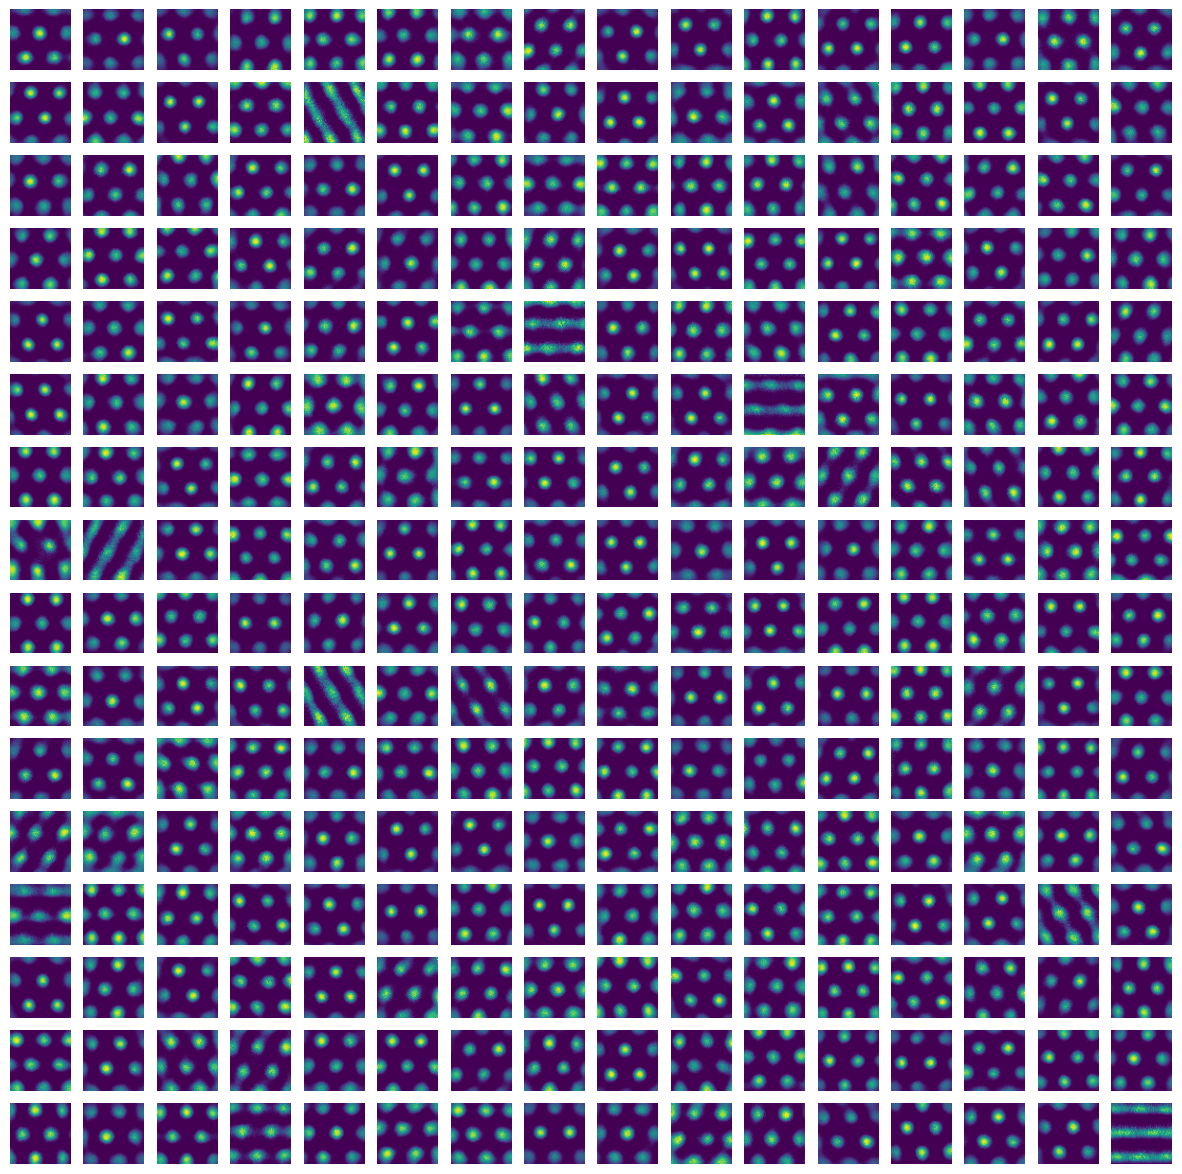

In [14]:
ns = 16 # ns x ns grid of unit ratemaps
count = 0
fig, ax = plt.subplots(ns,ns, figsize = (15,15))
for i in range(ns):
    for j in range(ns):
        im = ax[i,j].imshow(ratemaps[inds][count])
        ax[i,j].axis("off")
        count += 1